# Sheet 1

In [1]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
plt.rcParams['font.size'] = 9
plt.rcParams['figure.constrained_layout.use'] = True

## Principal Component Analysis
### (a)

In [2]:
def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], "Got n_components larger than dimensionality of data!"
    
    # center the data
    data = data - data.mean(axis=1, keepdims=True)
    
    # compute X times X transpose
    XXT = data @ data.T
    
    # compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(XXT)
    
    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    idx = eigenvalues.argsort()[::-1][:n_components]
    eigenvectors = np.real_if_close(eigenvectors[:, idx].T)
    
    # compute X_projected, the projection of the data to the components
    X_projected = eigenvectors @ data
    
    # return the n_components first components and the pca projection of the data
    return eigenvectors, X_projected

In [3]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

# apply your implementation
n_components = 2
components, projection = pca(data, n_components=n_components)

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), 'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), 'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [4]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')

for (label, count) in zip(*np.unique(labels, return_counts=True)):
    print(f'- {label_names[int(label)]}: {count} samples')

features.shape=(116, 2233), labels.shape=(2233,)
- b: 999 samples
- c: 864 samples
- q: 370 samples


Normalize the data

In [5]:
# report range of features
minmax = np.array([features.min(axis=1), features.max(axis=1)])
print('Feature ranges: [Min Max]')
print(minmax.T)

# normalize the data
feature_mean = np.mean(features, axis=1, keepdims=True)
feature_std = np.std(features, axis=1, keepdims=True)
features = (features - feature_mean) / feature_std

# check that the normalization is correct
assert np.allclose(features.mean(axis=1), 0), 'Expected zero mean'
assert np.allclose(features.var(axis=1), 1), 'Expected unit variance'

print('Normalization successful!')

Feature ranges: [Min Max]
[[ 5.85756813e-01  1.05630769e+00]
 [-3.24000000e-01  3.00100000e-01]
 [-1.39627830e+02  1.45816928e+02]
 [ 1.16525247e+01  2.07139564e+04]
 [ 9.98603722e+04  1.00145817e+05]
 [-9.99999993e-01 -9.78291749e-01]
 [ 1.49256830e+05  2.72598694e+06]
 [ 9.40234084e+01  2.31315841e+05]
 [ 1.55058365e+05  2.72866252e+06]
 [-1.34437843e+05  5.92927220e+04]
 [-9.66193677e+04  1.88237841e+05]
 [ 1.49077993e+05  2.72585060e+06]
 [ 1.29283681e+04  1.97132541e+05]
 [ 1.29283681e+04  1.97132541e+05]
 [ 6.18900000e-01  9.55500000e-01]
 [-4.62300000e-01  3.00100000e-01]
 [-1.39641800e+02  1.41843300e+02]
 [ 5.80095404e-01  1.11152547e+00]
 [-4.43773666e-01  3.02507039e-01]
 [-1.39644198e+02  1.41836244e+02]
 [-1.00000000e+00  2.91087571e+01]
 [ 0.00000000e+00  1.99783294e+02]
 [ 9.98603582e+04  1.00141843e+05]
 [ 9.46536229e-01  9.99832925e-01]
 [ 1.70081963e+04  2.53797090e+05]
 [-1.55073089e+05  5.06801916e+04]
 [-5.78572360e+04  2.00911175e+05]
 [ 5.10830474e+04  2.46243827

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [6]:
components, projection = pca(features, n_components=2)

In [7]:
def scatter_plots(projection, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2.54, 5.5 / 2.54), sharey=True)
    ax1.scatter(*projection, alpha=0.3, s=20, rasterized=True)

    # Color the points according to the labels and add a legend.
    cmap = ListedColormap(['C0', 'C1', 'C2'])
    scatter = ax2.scatter(*projection, c=labels, cmap=cmap, alpha=0.2, s=20, rasterized=True)
    ax2.legend(handles=scatter.legend_elements()[0], labels=label_names, loc='upper left')

    for ax in (ax1, ax2):
        ax.set_xlabel('1st Component')
        ax.set_ylabel('2nd Component')
        ax.label_outer()

    if title is not None:
        ax1.annotate(
            title,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='silver', boxstyle='round'),
        )

    plt.show()

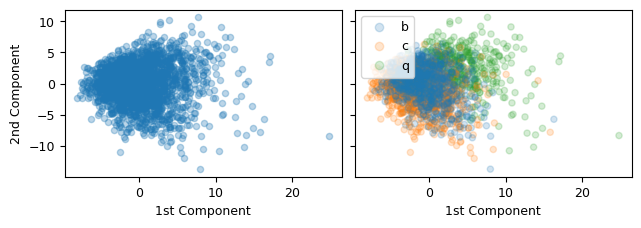

In [8]:
scatter_plots(projection)

Without colors, one can not distinct the different classes at all. Even with colors, the classes have a lot of overlap, but a general trend can be seen.

## Nonlinear Dimension Reduction

### (a)

In [9]:
reducer = umap.UMAP(n_components=2)
projection = reducer.fit_transform(features.T).T

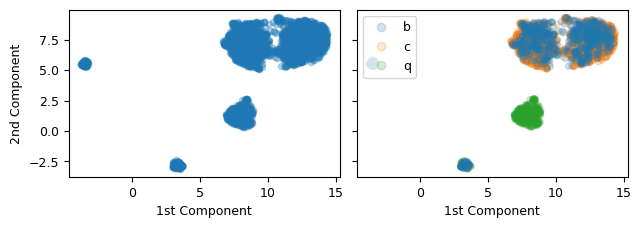

In [10]:
scatter_plots(projection)

Without colors, one might think tht the separation looks good, but with colors, it becomes clear that only the (green) light quarks and some bottom quarks are well separated. There remain two big clusters where both (orange) charm and (blue) bottom quarks are mixed.

### (b)

c:\ProgramData\Miniconda3\envs\phys\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.26983069e-15 3.25143202e-06 1.97871866e-06 5.03854062e-06]
not reaching the requested tolerance 4.664063453674316e-06.
  _, diffusion_map = lobpcg(
c:\ProgramData\Miniconda3\envs\phys\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\ProgramData\Miniconda3\envs\phys\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


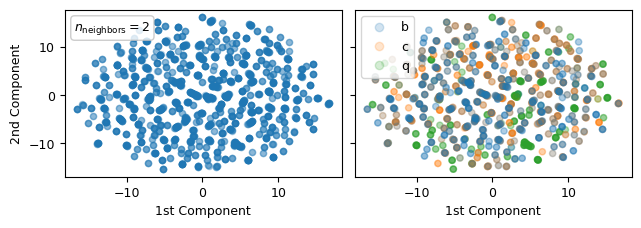

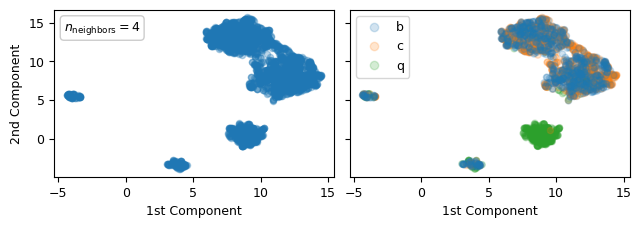

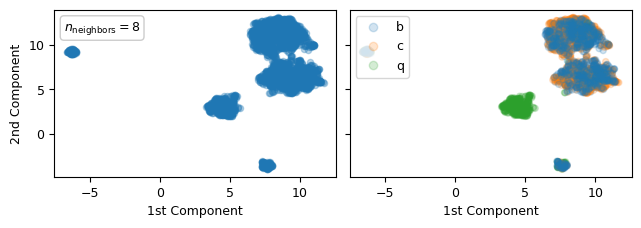

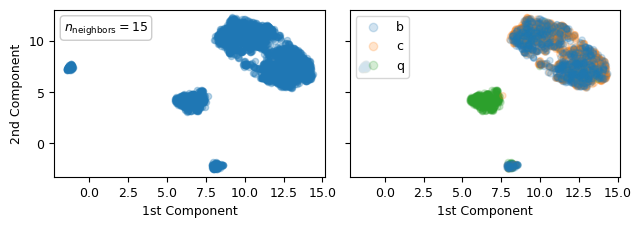

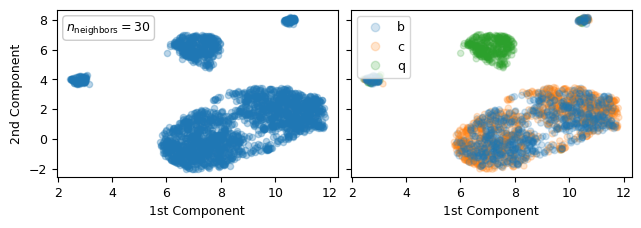

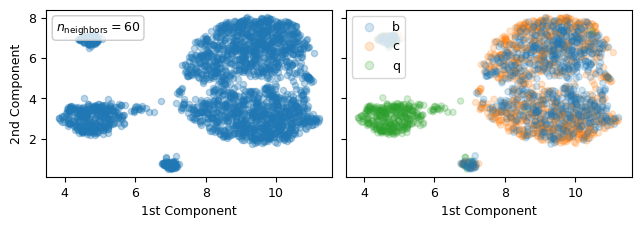

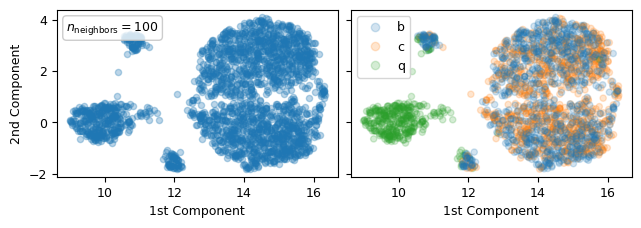

In [11]:
for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2)
    projection = reducer.fit_transform(features.T).T
    scatter_plots(projection, title=fr"$n_{{\text{{neighbors}}}} = {n_neighbors}$")

With increasing value of `num_neighbors`, the points in the clusters and the clusters themselves get closer to each other. The general quality of the embedding does not change much as the clearly separated light quarks stays well separated, but the mix of charm and bottom quarks remain, although those two clusters get very close to becomming one.

## RANSAC

The fraction $p$ describes the probability that a given sample is an inlier. The probability that subset of $m$ samples is free of outliers is thus given as

$$ P_m = p^m. $$

When repeatedly drawing $m$-subsets for $r$ iterations, the probability that all of them contain at least one outlier is given as $(1 - P_m)^r$, thus the probability that _not_ all of them contain an outlier is given as

$$ P = 1 - (1 - P_m)^r. $$

Solving this equation for $r$ with $P=0.99$ gives
$$ r = \frac{\log(1 - P)}{\log(1 - P_m)} = \frac{-2}{\log(1 - p^m)}. $$